In [1]:
#general imports
import fedot
import matplotlib.pyplot as plt
import logging
logging.raiseExceptions = False
import numpy as np
import pandas as pd

#imports to create a fedot model
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
from fedot.core.utils import fedot_project_root

In [3]:
#building a fedot model
temp = pd.read_csv('temperature_ts.csv')[:200]
idx = np.array(temp.index)
ts = np.array(temp['value'])

horizon = 30
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=horizon))

train_input = InputData(idx=idx,
                            features=ts,
                            target=ts,
                            task=task,
                            data_type=DataTypesEnum.ts)
train_data, test_data = train_test_data_setup(train_input, validation_blocks=2)
model = Fedot(problem='ts_forecasting',
                  task_params=task.task_params,
                  timeout=5,
                  n_jobs=1,
                  cv_folds=2, validation_blocks=2, preset='fast_train')

2022-09-15 11:05:03.411065: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
#fit fedot model
pipeline = model.fit(train_data)

Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

Metric evaluation error: Per-column arrays must each be 1-dimensional
Metric evaluation error: Per-column arrays must each be 1-dimensional
Metric evaluation error: Per-column arrays must each be 1-dimensional
Metric evaluation error: Per-column arrays must each be 1-dimensional
Metric evaluation error: Per-column arrays must each be 1-dimensional
Metric evaluation error: Per-column arrays must each be 1-dimensional
Metric evaluation error: Per-column arrays must each be 1-dimensional
Metric evaluation error: Per-column arrays must each be 1-dimensional


Generations:   1%|          | 1/100 [02:54<?, ?gen/s]

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

 77%|███████▋  | 771/1000 [02:05<00:37,  6.16trial/s, best loss: 4.030442865505675] 


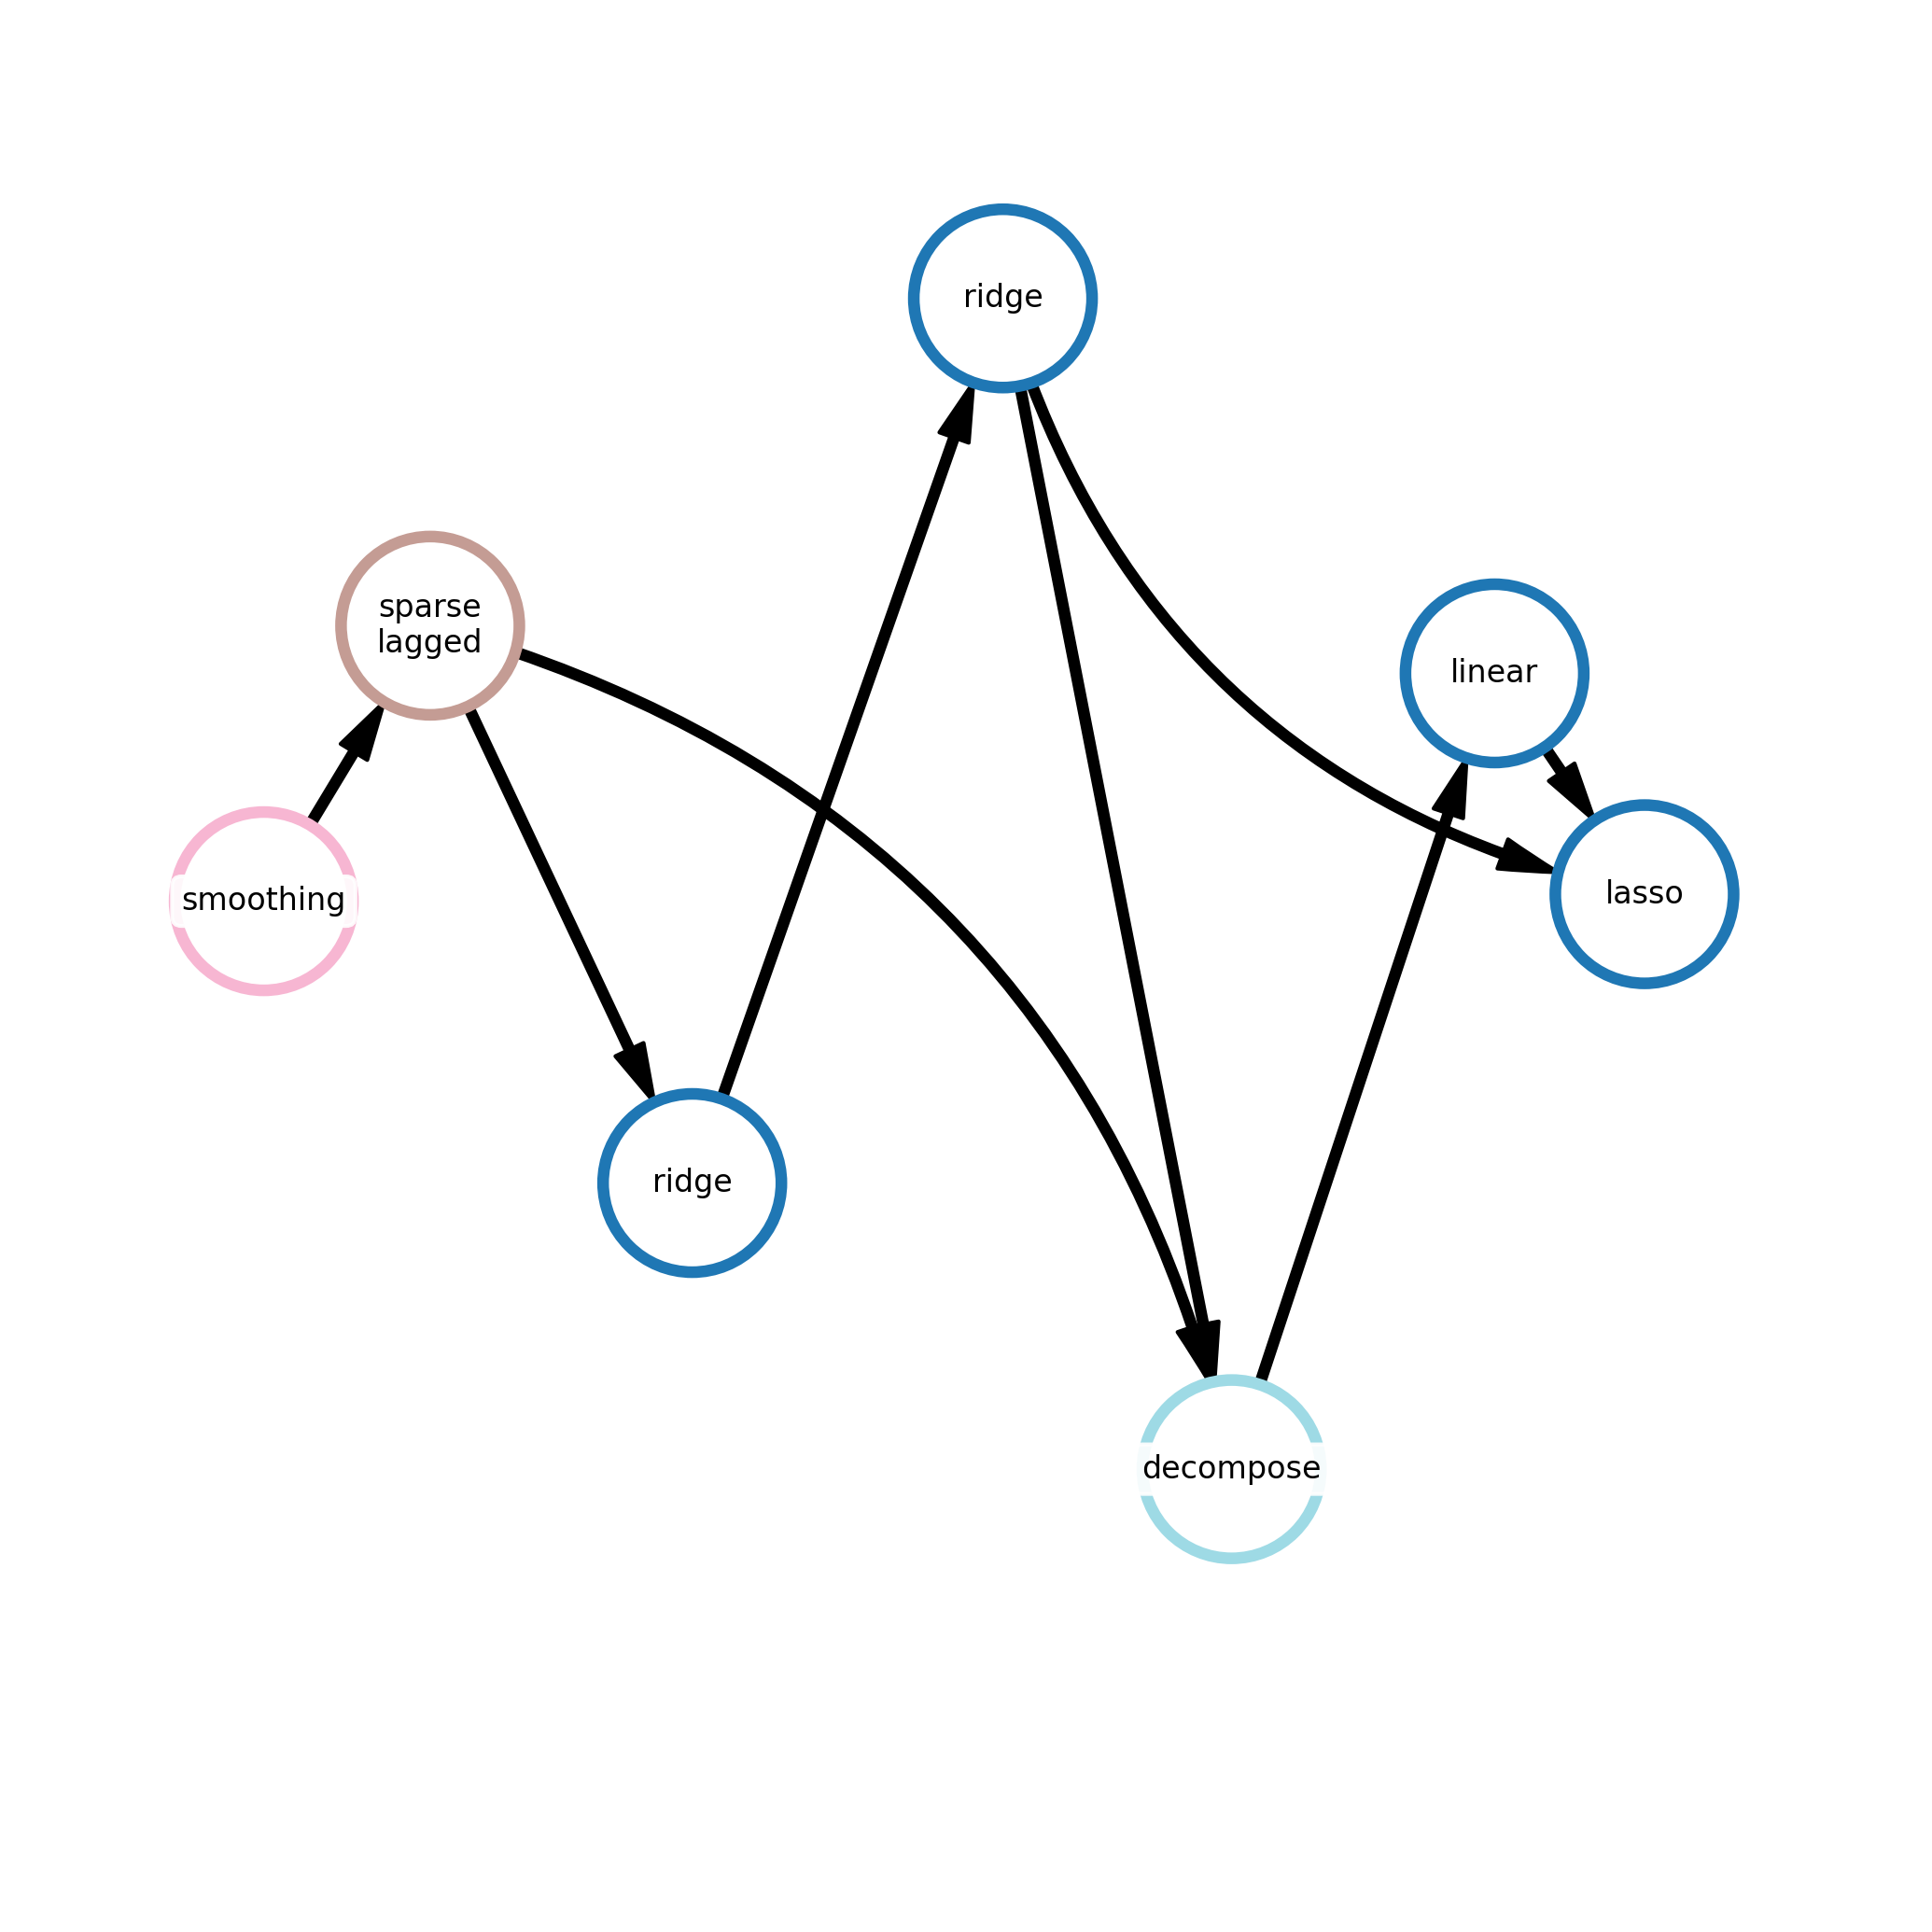

{'rmse': 15.060323512450724, 'mae': 12.883847572251282, 'mape': 0.046243225666891624}


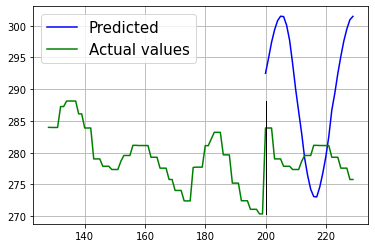

In [5]:
#see the results
pipeline.show()
forecast = model.predict(test_data)
target = np.ravel(test_data.target)
print(model.get_metrics(metric_names=['rmse', 'mae', 'mape'], target=target))
model.plot_prediction()

In [6]:
#imports for working with other pipelines

from fedot.core.optimisers.adapters import PipelineAdapter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum
from fedot.core.pipelines.tuning.tuner_interface import HyperoptTuner
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.optimisers.composer_requirements import ComposerRequirements
import datetime

In [10]:
#this function computes confidence intervals given a list of np arrays
def f(quantile,arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    up = []
    low = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        q_up = np.quantile(x, 1-quantile)
        up.append(q_up)
        q_low = np.quantile(x,quantile)
        low.append(q_low)
    up = np.array(up)
    low = np.array(low)
    return {'up':up,'low':low}


#this function makes confidece intervals
def conf_int_maker(model = model,
                   ts = ts,
                   quantile = 0.1,
                   number_models = 10, 
                   plot = True, 
                   tuner = 'default'):
    horizon = model.params.task.task_params.forecast_length
    train_data = model.train_data
    if tuner == 'default':
        task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=horizon))
        metric_function = RegressionMetricsEnum('rmse')
        default_tuning_iterations_number = 10
        timeout_for_tuning = 1
        composer_requirements = ComposerRequirements()
        composer_requirements.validation_blocks = 2
        composer_requirements.n_jobs= -1
        composer_requirements.show_progress = True
        train_data = train_data

        tuner = TunerBuilder(task = task) \
            .with_tuner(PipelineTuner) \
            .with_metric(metric_function) \
            .with_iterations(default_tuning_iterations_number) \
            .with_timeout(datetime.timedelta(minutes=timeout_for_tuning)) \
            .with_requirements(composer_requirements) \
            .build(train_data)
    fits = []
    for ind in model.history.individuals[-1]:
        fits.append(ind.fitness.value)
    fits = np.sort(np.array(fits))

    predictions = []
    for ind in model.history.individuals[-1]:
        if ind.fitness.value<=fits[number_models]:
            pipeline = PipelineAdapter().restore(ind.graph)
            tuned_pipeline = tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            predictions.append(preds)
    res= f(quantile = quantile, arrays = predictions)
    if plot:
        fig,ax = plt.subplots()
        for i in range(len(predictions)):
            ax.plot(predictions[i], color = 'pink')
        ax.plot(res['up'], color = 'red', label  = 'up')
        ax.plot(res['low'], color = 'green', label  = 'low')
        ax.plot(forecast, color = 'blue', label = 'forecast')
        ax.plot(ts[-horizon:],color = 'black', label = 'actual ts')
        plt.legend()
    return res

100%|██████████| 10/10 [00:00<00:00, 11.63trial/s, best loss: 5.517822850373818]


{'up': array([289.42012419, 294.78703568, 299.672981  , 305.83115016,
        310.89916578, 312.21453524, 311.57734057, 312.01575286,
        314.53444064, 315.01858842, 313.29241283, 308.13796144,
        301.0678385 , 293.27217311, 286.9531941 , 281.9909574 ,
        277.68803487, 273.2441035 , 269.93690655, 268.18410005,
        269.03753874, 273.21089337, 278.28469276, 283.90485917,
        289.68005075, 295.19078004, 300.18075061, 306.32087502,
        311.31791264, 312.66501269]),
 'low': array([270.82275981, 274.26093637, 279.09542592, 285.40524987,
        292.54223882, 300.16961272, 307.22241918, 308.62019042,
        305.28469828, 300.21527369, 294.40187702, 287.53596713,
        283.43927588, 279.99666787, 274.59548113, 270.1404069 ,
        266.83848062, 264.82194001, 264.69529073, 265.02360322,
        265.79896683, 267.67526693, 267.45034753, 267.33149128,
        269.70815499, 274.37485342, 280.43374786, 287.27258522,
        294.91989561, 302.41248319])}

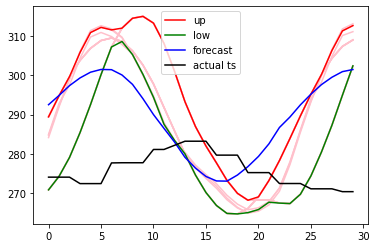

In [11]:
conf_int_maker()